# Gaussian hypothesis test

In this notebook, we'll take a look at two relatively simple statistical tests that can be used to test whether a data sample is consistent with a Gaussian distribution with known mean and width. 

## Kolmogorov-Smirnov Test

The Komogorov-Smirnov (KS) test is desined to detect differences in observed distributions from a model. This test is typically used when you have lots of data available (which is of course the typical scenario you'll be working in). It's not always the most powerful test because its designed to catch all kinds of deviations from your model. 

The example in this notebook uses a Gaussian distribution as the numm hypothesis $H_{0}$, with parameters $\mu=0, \sigma = 1$. 

In [1]:
%matplotlib inline

import numpy,pandas,random
from scipy.stats import norm

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

mu_H0 = 0
sigma_H0 = 1

The KS test is based on the *cumulative distribution function* of the model vs the *empirical cumulative distribution* of the data. The empirical distribution $F_{data}(x)$ is given by, 

$$
F_{data}(x) = \frac{\mathrm{number~of~data~values~} < x}{n}
$$

where $n$ is the number of entries in our data set. 

In [2]:
xrange = numpy.linspace(-5,5,100)

# We are passing the sigma as an argument as we'll use it later
def cdf(x):
    return norm.cdf(x,mu_H0,sigma_H0)

def emp_cdf(data,x):
    return float(len(data[data < x]))/len(data)

To calculate the distribution of the KS test statistic, 

$$
D = \mathrm{sup}_{x}\left|F_{data}(x)-F(x)\right|,
$$

In [3]:
def D(data):
    diffs = [abs(cdf(x)-emp_cdf(data,x)) for x in xrange]
    return max(diffs)

we generate Monte Carlo samples from $H_{0}$. Let's assume our data sample will have 500 events in each sample and we'll use 1000 samples. 

In [4]:
n_events = 500
n_samples = 1000

In [5]:
D_list = []
for i in range(n_samples):
    x = norm.rvs(mu_H0,sigma_H0,size=n_events)
    Dmc = D(x)
    D_list.append(Dmc)

We can plot the distribution of the test-statistic under $H_{0}$. From this distribution, we can determine the region $w$ such that, 

$$
\int_{w}f(D|H_{0}) = 0.05
$$
i.e we choose $\alpha=0.05$. 

This is equivalent to choosing a minimum value of $D$, $D_{\mathrm{min}}$ such that, 

$$
\int_{D_{min}}^{\infty}f(D|H_{0})dD = P(D>D_\mathrm{min}|H_{0}) = 0.05
$$

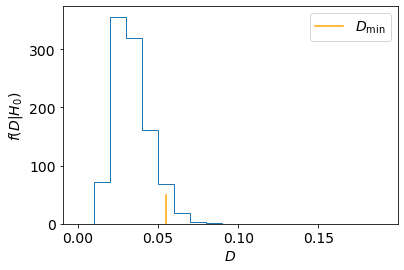

In [6]:
bins = numpy.arange(0,0.2,0.01)

plt.hist(D_list,histtype='step',bins=bins)
plt.xlabel("$D$")
plt.ylabel("$f(D|H_{0})$")

D_list.sort()
D_min = D_list[int(n_samples*0.95)]

plt.plot([D_min,D_min],[0,50],label="$D_{\mathrm{min}}$",color='orange')
plt.legend()
plt.savefig("KS_dist.pdf")
plt.show()

We have chosen the size of the test ($\alpha$) as 0.05, meaning that the Type-I error of our test is 5%. This can easily be seen since we would reject $H_{0}$ whenever $D>D_{\mathrm{min}}$, and $D_{\mathrm{min}}$ is chosen such that $P(D>D_{\mathrm{min}}|H_{0})=0.05$. 

The power of a hypothesis test tells us the rate at which we would reject $H_{0}$ if $H_{1}$ is true. We therefore need to know  what the distribution of $D$ would be under some other  hypothesis $H_{1}$. Let's consider $H_{1}$ as Gaussian distributions with different values of $\mu$ and $\sigma$. Let's start with $H_{1}$ being a Gaussian with $\mu=0.2$, $\sigma=1$. 

In [7]:
mu_H1 = 0.2
sigma_H1 = 1

In [8]:
D_list_H1 = []

for i in range(n_samples):
    x = norm.rvs(mu_H1,sigma_H1,size=n_events)
    Dmc = D(x)
    D_list_H1.append(Dmc)

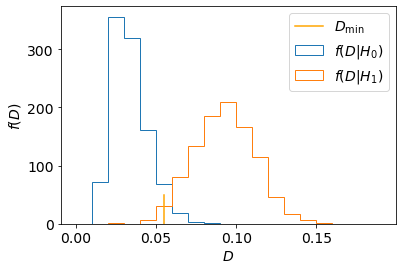

In [9]:
plt.hist(D_list,histtype='step',bins=bins,label="$f(D|H_{0})$")
plt.hist(D_list_H1,histtype='step',bins=bins,label="$f(D|H_{1})$")

plt.plot([D_min,D_min],[0,50],label="$D_{\mathrm{min}}$",color='orange')

plt.xlabel("$D$")
plt.ylabel("$f(D)$")
plt.legend()
plt.savefig("KS_dist_with_H1.pdf")

The power is calculated as $P(D>D_{\mathrm{min}}|H_{1})$.

In [10]:
print(len(list(filter(lambda x : x>D_min,D_list_H1)))/n_samples)

0.986


Now,  let's see how the power changes as we vary $\mu$ and $\sigma$.  

In [11]:
r_mu_H1    = numpy.arange(0,0.32,0.02)
r_sigma_H1 = numpy.arange(0.5,2.1,0.1)

In [12]:
power_vs_mu_KS = []
power_vs_sigma_KS = []

for mu_H1_x in r_mu_H1: 
    n_pass = 0
    for i in range(n_samples):
        x = norm.rvs(mu_H1_x,sigma_H0,size=n_events)
        Dmc = D(x)
        if Dmc > D_min : n_pass +=1  
    power_vs_mu_KS.append(float(n_pass)/n_samples)

for sigma_H1_x in r_sigma_H1: 
    n_pass = 0
    for i in range(n_samples):
        x = norm.rvs(mu_H0,sigma_H1_x,size=n_events)
        Dmc = D(x)
        if Dmc > D_min : n_pass +=1  
    power_vs_sigma_KS.append(float(n_pass)/n_samples)


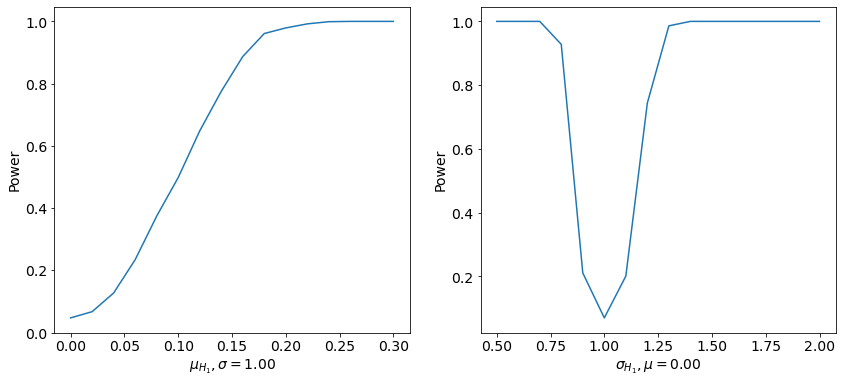

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

ax1.plot(r_mu_H1,power_vs_mu_KS)
ax1.set_xlabel("$\\mu_{H_{1}}, \\sigma=$%.2f"%sigma_H0)
ax1.set_ylabel("Power")
ax2.plot(r_sigma_H1,power_vs_sigma_KS)
ax2.set_xlabel("$\\sigma_{H_{1}}, \\mu=$%.2f"%mu_H0)
ax2.set_ylabel("Power")
plt.savefig("power_KS.pdf")

## Wald–Wolfowitz runs test

Another simple test we can use is the Wald-Wolfowitz runs test. For a sequence of independent  binary random values, we define a run as a maximal segment of the sequence with the same outcome. E.G 00011100000111 has a 4 runs, 2 of which are 0's and 2 of which are 1's. 

In testing whether an observed sample is consistent with a specified hypothesis like a Gaussian, we can bin our data in a histogram and assign a $+$ to bins for which the density is greater than the Gaussian density and a $-$ to when the density is  smaller. 

The test statistic is the number of runs $N$. If we represent the data as "0" or "1", we can create a rather simple function to count the number of runs in a sequence. 

In [14]:
def N(data):
    n = 1 
    for i,x in enumerate(data[0:-1]): 
        if data[i+1] != x:  n+=1
    return n

Since we will assume around 500 events, we should pick something like 50 bins to determine the density from the observed data. 

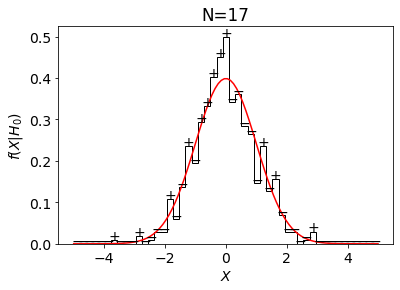

In [15]:
bins = numpy.linspace(-5*sigma_H0,5*sigma_H0,50)
x = norm.rvs(mu_H0,sigma_H0,size=n_events)

res = plt.hist(x,density=True,color='black',histtype='step',bins=bins)
plt.plot(xrange,norm.pdf(xrange,mu_H0,sigma_H0),color='red')

diffs = []

for i in range(len(bins)-1):
  xx = 0.5*(res[1][i]+res[1][i+1])
  yy = res[0][i]
  if yy>norm.pdf(xx,mu_H0,sigma_H0):
    plt.text(xx,yy,"$+$",horizontalalignment='center')
    diffs.append(1)
  else: 
    plt.text(xx,yy,"$-$",horizontalalignment='center')
    diffs.append(0)

nruns = N(diffs)
plt.xlabel("$X$")
plt.ylabel("$f(X|H_{0})$")
plt.title("N=%d"%nruns)
plt.savefig("Runs_ex.pdf")

Now lets see what the distribution of $N$ looks like under the null hypothesis $H_{0}$. 

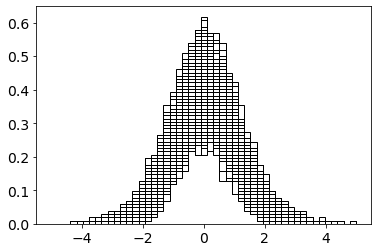

In [24]:
N_list = []

bins = numpy.linspace(-5*sigma_H0,5*sigma_H0,50)
for i in range(n_samples):
    x = norm.rvs(mu_H0,sigma_H0,size=n_events)
    res = plt.hist(x,density=True,color='black',histtype='step',bins=bins)
    xx = [res[1][i]+0.5*(res[1][1]-res[1][0]) for i in range(len(bins)-1)]
    yy = res[0] 
    diffs = yy>norm.pdf(xx,mu_H0,sigma_H0)
    diffs = [int(d) for d in diffs]
    N_list.append(N(diffs))
    

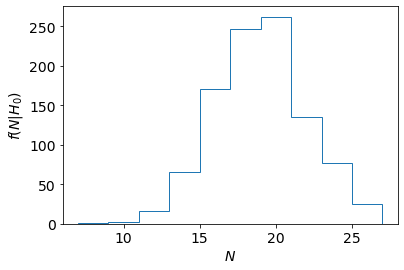

In [17]:
plt.hist(N_list,histtype='step')
plt.xlabel("$N$")
plt.ylabel("$f(N|H_{0})$")
plt.savefig("Runs_N_dist_ex.pdf")

In this case, large or small values of $N$, compared to the average would indicate deviation from the null hypothesis. We can find $w$ as the tail regions that integrate to $0.05$. This is just the same as finding the 2.5% and 97.5% quantiles of the distribution above. 

In [18]:
N_min,N_max = numpy.quantile(N_list,(0.025,0.975))
print(N_min,N_max)

13.0 23.049999999999955


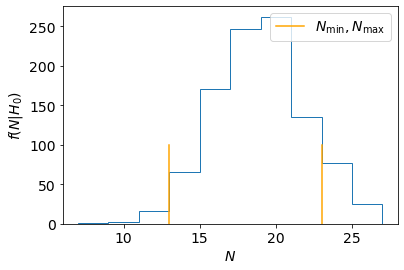

In [19]:
plt.hist(N_list,histtype='step')
plt.xlabel("$N$")
plt.ylabel("$f(N|H_{0})$")
plt.plot([N_min,N_min],[0,100],label="$N_\mathrm{min}, N_\mathrm{max}$",color='orange')
plt.plot([N_max,N_max],[0,100],color='orange')
plt.legend()
plt.savefig("Runs_N_dist_ex_with_qs.pdf")

Once again, we can determine the power of this test by calculating the probability we would reject the null hypothesis under some alternate hypothesis. Let's compare to the power of the KS test from before. 

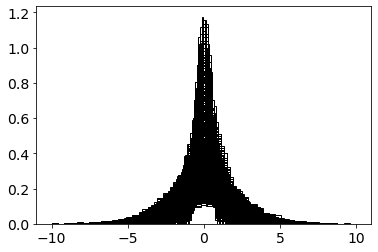

In [20]:
power_vs_mu_WW = []
power_vs_sigma_WW = []

for mu_H1_x in r_mu_H1:

    n_pass = 0 
    for i in range(n_samples):
        x = norm.rvs(mu_H1_x,sigma_H0,size=n_events)
        res = plt.hist(x,density=True,color='black',histtype='step',bins=bins)
        xx = [res[1][i]+0.5*(res[1][1]-res[1][0]) for i in range(len(bins)-1)]
        yy = res[0] 
        diffs = yy>norm.pdf(xx,mu_H0,sigma_H0)
        diffs = [int(d) for d in diffs]
        Nd = N(diffs)
        if Nd >= N_max or Nd <= N_min: n_pass+=1
    power_vs_mu_WW.append(float(n_pass)/n_samples)

for sigma_H1_x in r_sigma_H1:
    
    n_pass = 0 
    for i in range(n_samples):
        x = norm.rvs(mu_H0,sigma_H1_x,size=n_events)
        bins = numpy.linspace(-5*sigma_H1_x,5*sigma_H1_x,50)
        res = plt.hist(x,density=True,color='black',histtype='step',bins=bins)
        xx = [res[1][i]+0.5*(res[1][1]-res[1][0]) for i in range(len(bins)-1)]
        yy = res[0] 
        diffs = yy>norm.pdf(xx,mu_H0,sigma_H0)
        diffs = [int(d) for d in diffs]
        Nd = N(diffs)
        if Nd >= N_max or Nd <= N_min: n_pass+=1
    power_vs_sigma_WW.append(float(n_pass)/n_samples)
    
    

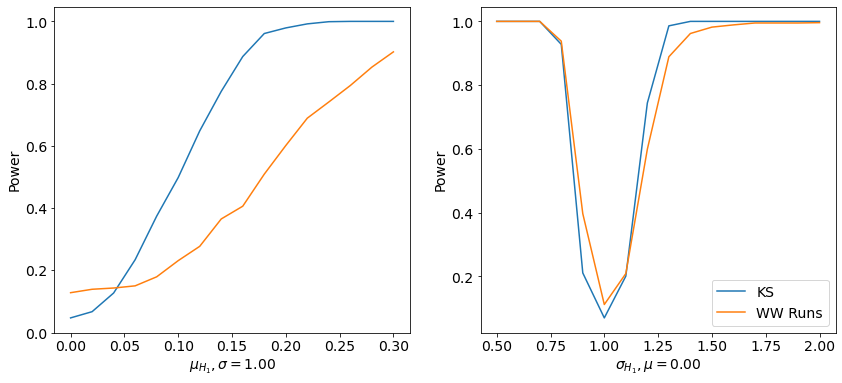

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

ax1.plot(r_mu_H1,power_vs_mu_KS,label="KS")
ax1.plot(r_mu_H1,power_vs_mu_WW,label="WW Runs")
ax1.set_xlabel("$\\mu_{H_{1}}, \\sigma=$%.2f"%sigma_H0)
ax1.set_ylabel("Power")
ax2.plot(r_sigma_H1,power_vs_sigma_KS,label="KS")
ax2.plot(r_sigma_H1,power_vs_sigma_WW,label="WW Runs")
ax2.set_xlabel("$\\sigma_{H_{1}}, \\mu=$%.2f"%mu_H0)
ax2.set_ylabel("Power")
ax2.legend()
plt.savefig("power_comparison.pdf")